In [1]:
from basic_imports import *
from torch_imports import *
import string
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

In [2]:
class Config:
    data_dir = 'data_raw.csv'
    batch_size = 64
    hidden_dim = 200
    lr = 1e-3
    device = 'cuda:2'
    num_layers = 2
    trn_pct = 0.8
    batch_len = 17


## Clean data

In [3]:
def get_data(config):
    data = pd.read_csv(config.data_dir)
    data_clean = []

    for o in data.values:
        for oo in o:
            if type(oo) == float or oo == "NEXTEPISODE":
                continue
            if oo[0] == '(':
                continue
            data_clean.append(oo)
    idx2char = ['[PAD]', '[EOS]', '[SOS]', ]
    idx2char += list(set([character for line in data_clean for character in line]))
    char2idx = {o:i for i,o in enumerate(idx2char)}
    
    data_train, data_val = np.split(data_clean, [int(len(data_clean)*config.trn_pct)])
    return idx2char, char2idx, data_train, data_val

## Dataset and Dataloader

In [4]:
class StarTrekDataset(Dataset):
    def __init__(self, config, idx2char, char2idx, data):
        self.data = data
        self.vocab = self.char2idx = char2idx
        self.idx2char = idx2char
        self.batch_len = config.batch_len
        self.get_sequences()
        
    def __getitem__(self, i):
        return self.data[i]
    
    def __len__(self):
        return len(self.data)

    def get_sequences(self):
        print("process dataset")
        seqs = [ ['[SOS]']+list(o)+['[EOS]'] for o in self.data]
        seqs = [oo for o in seqs for oo in o]
        sequences = []
        for i in progress_bar(range(len(seqs)-self.batch_len)):
            sequences.append([self.vocab[o] for o in seqs[i:i+self.batch_len]])
        self.data = sequences

## Model

In [5]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_dim, vocab_size, layers, model_path='model.pt'):
        super().__init__()
        self.embedding = nn.Embedding(input_size, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, out_features=vocab_size)
        self.dropout = nn.Dropout(p=0.3)
        self.model_path = Path(model_path)
        if self.model_path.exists():
            self.load_state_dict(torch.load(self.model_path))
    
    def forward(self, inputs, states=None):
        x = inputs
        x = self.embedding(x)
        y, states = self.lstm(x, states)
        y_last = self.dropout(y)
        y_last = self.fc(y_last)
        return y_last, states

## System

In [9]:
class System:
    
    def __init__(self, ds_trn, ds_val, config, save_path='model.pt'):
        self.ds_trn = ds_trn
        self.ds_val = ds_val
        self.config = config
        self.vocab = ds_trn.vocab
        self.idx2char = ds_trn.idx2char
        self.model = Model(len(self.vocab), config.hidden_dim, len(self.vocab), config.num_layers).to(config.device)
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=config.lr)
        self.save_path = save_path
        
        if Path(self.save_path).exists():
            self.model.load_state_dict(torch.load(self.save_path))
            
    def save(self, name=None):
        if not name: name = self.save_path
        torch.save(self.best_weight, name)

    
    def get_dataloader(self, stage):
        def collate_fn(batch):
            batch = np.array(batch)
            return torch.from_numpy(batch[:,:-1]).long(), torch.from_numpy(batch[:,1:]).long()
        
        if stage=='train':
            return DataLoader(self.ds_trn, batch_size=self.config.batch_size, collate_fn=collate_fn, shuffle=True)
        elif stage=='val':
            return DataLoader(self.ds_val, batch_size=self.config.batch_size, collate_fn=collate_fn, shuffle=False)
    
    
    def _acc_metric(self, y, preds):
        return torch.sum(preds == y).item()/len(y)
    
    
    def run_epoch(self, stage, mb, update_batch=100):
        if stage=='train':
            self.model.train()
        else:
            self.model.eval()
        loss_hist, metric_hist = [], []
        
        child_bar = enumerate(progress_bar(self.get_dataloader(stage), parent=mb))
        for ibatch, batch in child_bar:
            X, y = batch
            X = X.to(self.config.device)
            labels = y.to(self.config.device)
            
            # For one step
            self.optimizer.zero_grad()
            with torch.set_grad_enabled(stage=='train'):
                outputs, states = self.model( X )
                outputs = outputs.reshape(-1, len(self.vocab))
                labels = labels.reshape(-1)
                preds = outputs.argmax(dim=1)
                l = self.criterion(outputs, labels)
                if stage=='train':
                    l.backward()
                    self.optimizer.step()
            
            # evaluate
            loss_hist.append(l.item())
            metric_hist.append(self._acc_metric(labels, preds))
            if ibatch % update_batch==0: 
                mb.child.comment = f'{stage}: loss:{np.round(loss_hist[-1],3)}, metric:{np.round(metric_hist[-1],3)}'
        
        return dict(loss=np.mean(loss_hist), metric=np.mean(metric_hist))
    
    
    
    def fit(self, num_epochs):
        print("\t\tStart Training")
        self.best_perf = 0
        self.trn_loss_hist, self.val_loss_hist = [], []
        self.trn_met_hist, self.val_met_hist = [], []
        
        mb = master_bar(range(num_epochs))
        for epoch in mb:
            mb.main_bar.comment = f'Epoch:{epoch}'
            
            # train
            train_result = self.run_epoch('train', mb)
            # val
            val_result = self.run_epoch('val', mb)
            self.trn_loss_hist.append(train_result['loss'])
            self.val_loss_hist.append(val_result['loss'])
            self.trn_met_hist.append(train_result['metric'])
            self.val_met_hist.append(val_result['metric'])
            
            if self.val_met_hist[-1] > self.best_perf:
                self.best_perf = self.val_met_hist[-1]
                self.best_weight = deepcopy(self.model.state_dict())
                self.best_epoch = epoch
                self.save()
            
            mb.write(f"""Epoch {epoch}/{num_epochs - 1}, \t
                        trn_loss: {np.round(train_result['loss'],3)},
                        val_loss: {np.round(val_result['loss'], 3)},
                        val_acc: {np.round(val_result['metric'],3)}"""
                    )
            self.on_epoch_end(epoch)
    
    def on_epoch_end(self, i):
        samples = self.sample(200, sample_num=20)
        with open('generated.txt', 'a') as f:
            f.write(f'Epoch: {i}')
            for o in samples:
                f.write(self.decode(o) + '\n')
            f.write('\n\n\n')
    
    def sample(self, sample_length, sample_num=5, Temp=0.5):
        states = None
        x = torch.ones(sample_num, 1).long().to(self.config.device) * self.vocab['[SOS]']
        history = [x]
        for _ in range(sample_length):
            logits, states = self.model(history[-1], states)
            predicts = torch.multinomial(torch.softmax(logits[:,-1,:]/Temp, dim=-1), num_samples=1)
            history.append(predicts)
        outputs = torch.stack(history).squeeze().transpose(0, 1)
        return outputs.cpu().numpy()
    
    def decode(self, inputs):
        decoded = []
        for o in inputs:
            c = self.idx2char[o]
#             if c == '[EOS]':
#                 break
            decoded.append(c)
        return ''.join(decoded)
    
    def plot_loss(self, figname='losses.png'):
        num_epochs = len(self.trn_loss_hist)
        plt.plot(np.arange(num_epochs), self.trn_loss_hist, label='train_loss')
        plt.plot(np.arange(num_epochs), self.val_loss_hist, label='val_loss')
        plt.legend()
        plt.show()
        plt.savefig(figname)
        
    def plot_perf(self, figname='performance.png', metric_name='acc'):
        num_epochs = len(self.trn_met_hist)
        plt.plot(np.arange(num_epochs), self.trn_met_hist, label=f'train_{metric_name}')
        plt.plot(np.arange(num_epochs), self.val_met_hist, label=f'val_{metric_name}')
        plt.legend()
        plt.show()
        plt.savefig(figname)

In [10]:
def main():
    config = Config()
    idx2char, char2idx, data_trn, data_val = get_data(config)
    ds_trn = StarTrekDataset(config, idx2char, char2idx, data_trn)
    ds_val = StarTrekDataset(config, idx2char, char2idx, data_val)
    system = System(ds_trn, ds_val, config)
    system.fit(20)
    return system

In [17]:
if __name__ == "__main__":
    system = main()

## Performance

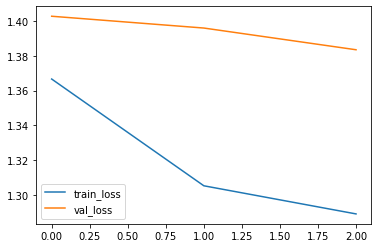

<Figure size 432x288 with 0 Axes>

In [18]:
system.plot_loss()

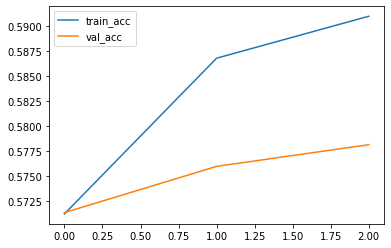

<Figure size 432x288 with 0 Axes>

In [19]:
system.plot_perf()

In [90]:
samples = system.sample(200, sample_num=40)
for o in samples:
    print(system.decode(o))

[SOS]RAEL: Captain, the high asteroid humans, am I have these thing they come on.[EOS][SOS]SPOCK: Spock, which will you go ago.[EOS][SOS]SCOTT: Here it might him, you'll conced that Kirk they path of his mind will discuss
[SOS]FINNEY: But do you know off, Captain.[EOS][SOS]KARA: I'm not function.[EOS][SOS]UHURA [OC]: We're extremely used with immediately.[EOS][SOS]KIRK: Kirk here. Of course, Lieutenan. Will you, I don't under once.[EOS][SOS]KIRK: Why not.
[SOS]SCOTT: Harry. We've even successed us up to Deela? Getting a gild! What you and the Fuhrer's possible. It's not doing up everything about you identified. Almost once, Mister Spock.[EOS][SOS]HENGIST: Rich! Doe
[SOS]SPOCK: Right, Doctor McCoy here. Or a silent, and HeTh, Rom, we K![EOS][SOS]ALICE, I know what lighten you. Narm. I am fines are prove that she correct, Proconsul.[EOS][SOS]SERGEANT: Affording to know how I wrote a m
[SOS]KIRK: That will be monitored ridium.[EOS][SOS]SALISH: Or do you mean, eleven, now that could unders